In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('fmcg.csv', index_col=['date'])
prices.head(10)

HINDUNILVR.NS      ITC.NS  NESTLEIND.NS  TATACONSUM.NS  \
date                                                                 
01-01-2018    1344.500000  262.299988   7863.200195     312.899994   
02-01-2018    1338.599976  260.750000   7863.549805     311.149994   
03-01-2018    1350.349976  261.149994   7860.100098     311.200012   
04-01-2018    1352.250000  261.549988   7869.250000     312.250000   
05-01-2018    1356.550049  262.899994   7856.750000     312.950012   
08-01-2018    1368.400024  265.600006   7941.149902     317.600006   
09-01-2018    1361.300049  270.549988   7779.250000     315.299988   
10-01-2018    1365.800049  269.399994   7846.649902     314.100006   
11-01-2018    1378.650024  269.799988   7874.299805     313.299988   
12-01-2018    1374.000000  267.549988   7789.250000     325.750000   

            BRITANNIA.NS  GODREJCP.NS    DABUR.NS  MCDOWELL-N.NS   MARICO.NS  \
date                                                                           
01-01-2018   2369.125000   657.500000  349.000000     728.760010  320.700012   
02-01-2018   2328.024902   654.366638  349.049988     718.400024  325.700012   
03-01-2018   2340.475098   657.599976  354.649994     719.630005  320.850006   
04-01-2018   2313.199951   659.633362  355.000000     737.770019  323.350006   
05-01-2018   2322.050049   660.033325  358.200012     790.650024  326.950012   
08-01-2018   2346.875000   663.133362  361.350006     784.700012  323.149994   
09-01-2018   2320.975098   658.833313  359.350006     768.909973  323.850006   
10-01-2018   2337.375000   652.299988  357.799988     766.080017  321.649994   
11-01-2018   2360.774902   656.666687  359.899994     765.530029  316.299988   
12-01-2018   2354.149902   660.866638  358.149994     761.849976  312.700012   

              COLPAL.NS  
date                     
01-01-2018  1102.599976  
02-01-2018  1100.750000  
03-01-2018  1098.349976  
04-01-2018  1094.349976  
05-01-2018  1100.699951  
08-01-2018  1117.699951  
09-01-2018  1120.599976  
10-01-2018  1118.250000  
11-01-2018  1125.050049  
12-01-2018  1139.599976

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

HINDUNILVR.NS      ITC.NS  NESTLEIND.NS  TATACONSUM.NS  \
date                                                                 
01-01-2018    1344.500000  262.299988   7863.200195     312.899994   
02-01-2018    1338.599976  260.750000   7863.549805     311.149994   
30-12-2020    2406.600098  211.149994  18379.250000     594.349976   
31-12-2020    2395.399902  209.000000  18390.250000     589.900024   

            BRITANNIA.NS  GODREJCP.NS    DABUR.NS  MCDOWELL-N.NS   MARICO.NS  \
date                                                                           
01-01-2018   2369.125000   657.500000  349.000000     728.760010  320.700012   
02-01-2018   2328.024902   654.366638  349.049988     718.400024  325.700012   
30-12-2020   3583.899902   749.150024  539.549988     577.750000  403.450012   
31-12-2020   3576.350098   740.150024  534.000000     578.250000  402.649994   

              COLPAL.NS  
date                     
01-01-2018  1102.599976  
02-01-2018  1100.750000  
30-12-2020  1579.000000  
31-12-2020  1565.250000

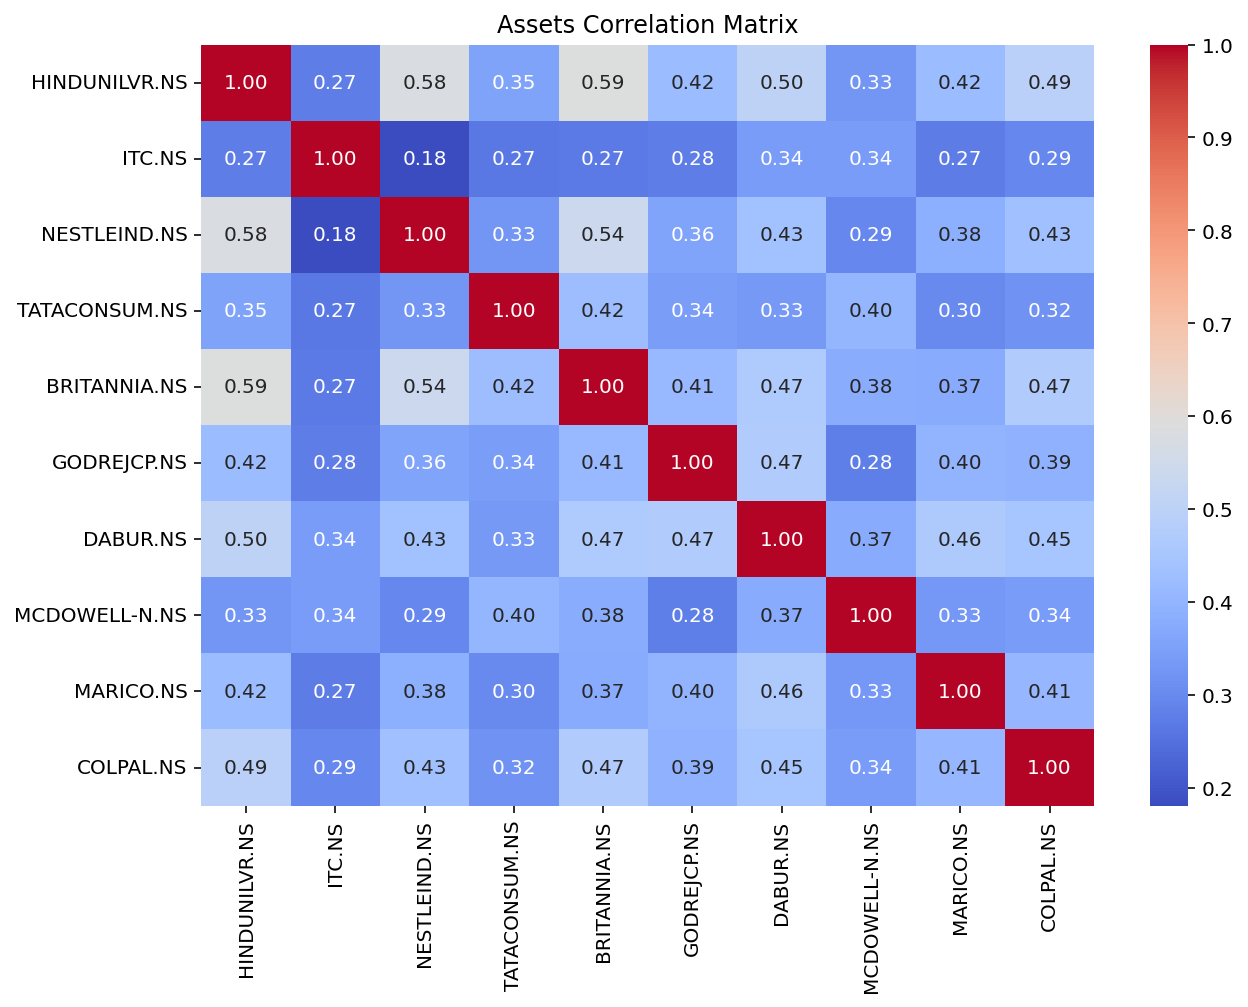

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('HINDUNILVR.NS', 'NESTLEIND.NS'), ('HINDUNILVR.NS', 'DABUR.NS'), ('MCDOWELL-N.NS', 'MARICO.NS'), ('MCDOWELL-N.NS', 'COLPAL.NS')]


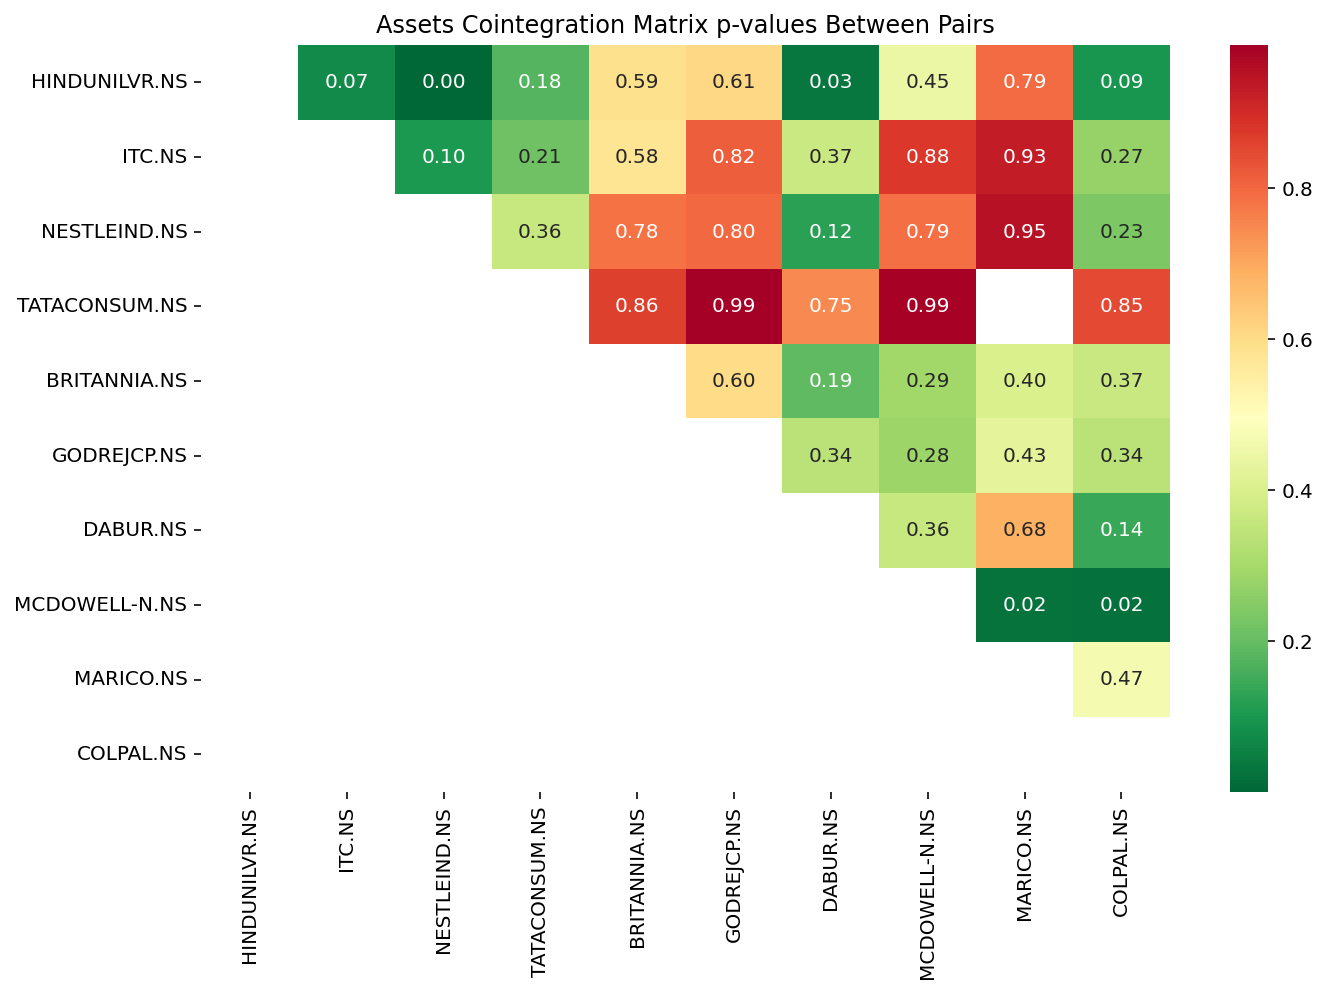

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'MCDOWELL-N.NS'
asset2 = 'COLPAL.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

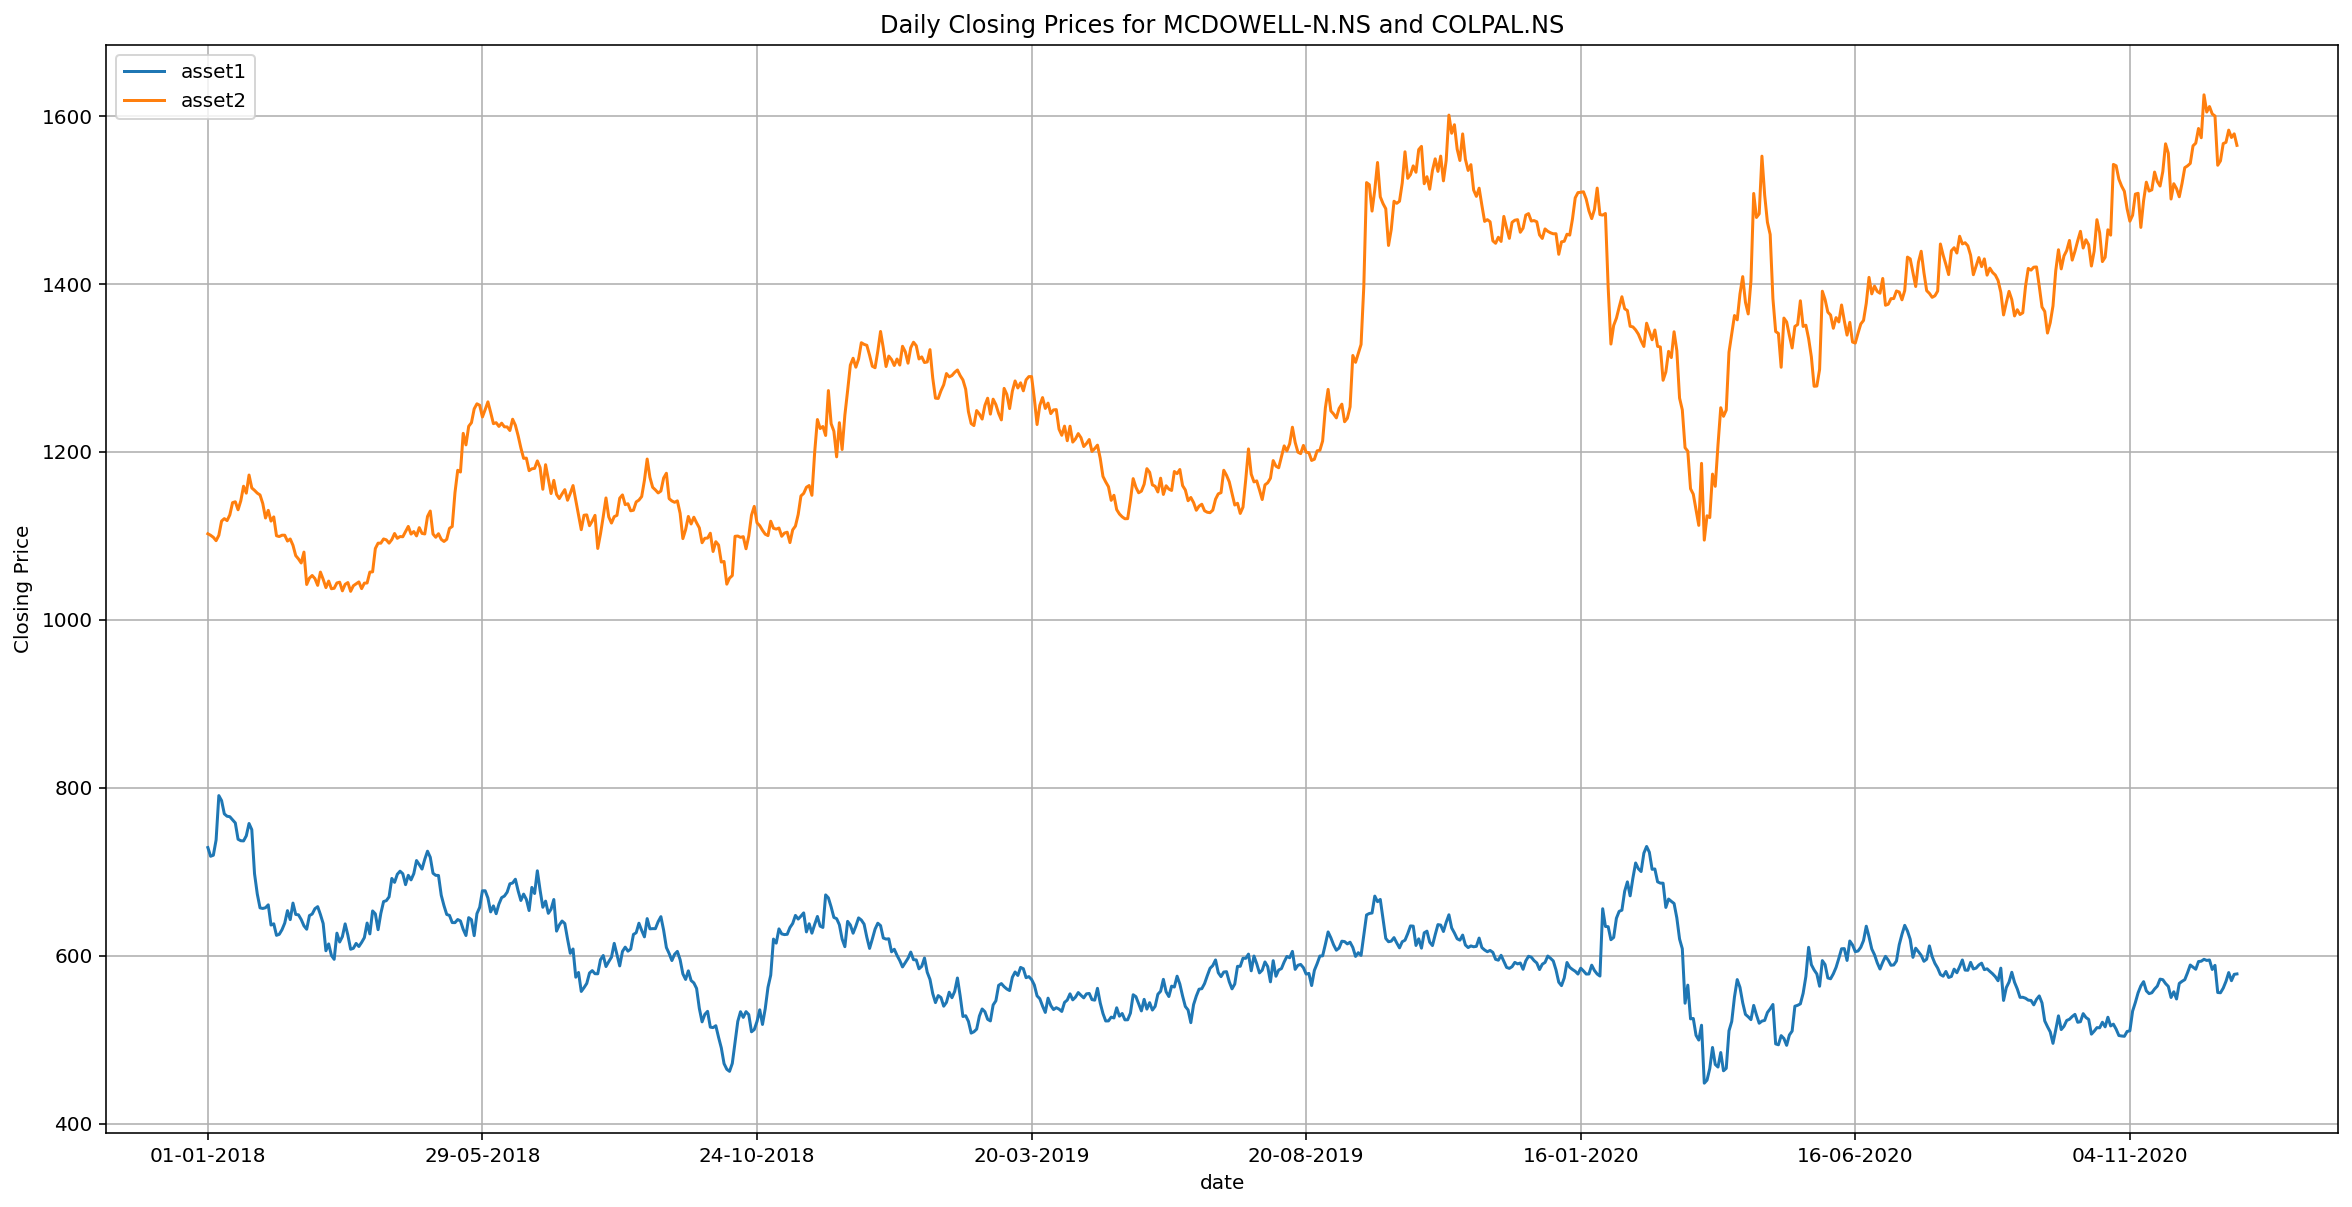

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                          2.702e+04
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                        0.00
Time:                        01:06:02   Log-Likelihood:                         -5010.1
No. Observations:                 740   AIC:                                  1.002e+04
Df Residuals:                     739   BIC:                                  1.003e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         2.1324      0.013    164.369      0.000       2.107       2.158
==============================================================================
Omnibus:                       31.481   Durbin-Watson:                   0.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.355
Skew:                          -0.253   Prob(JB):                     6.27e-05
Kurtosis:                       2.391   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

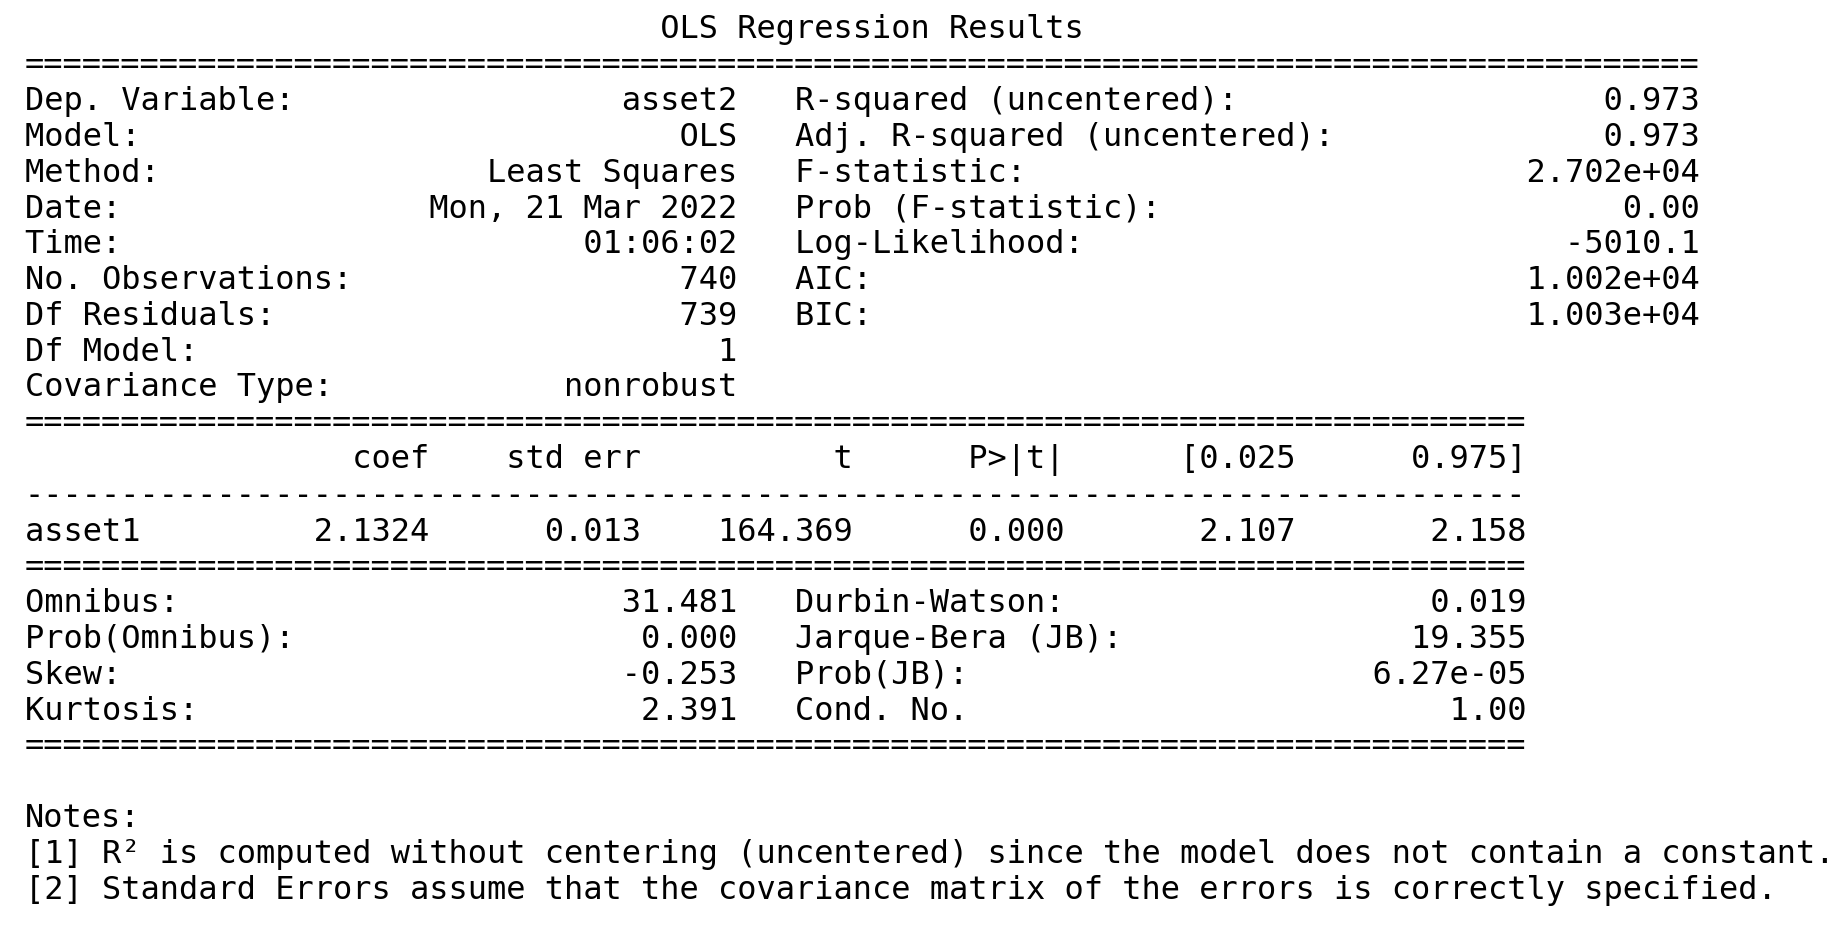

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  2.132406229242955


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

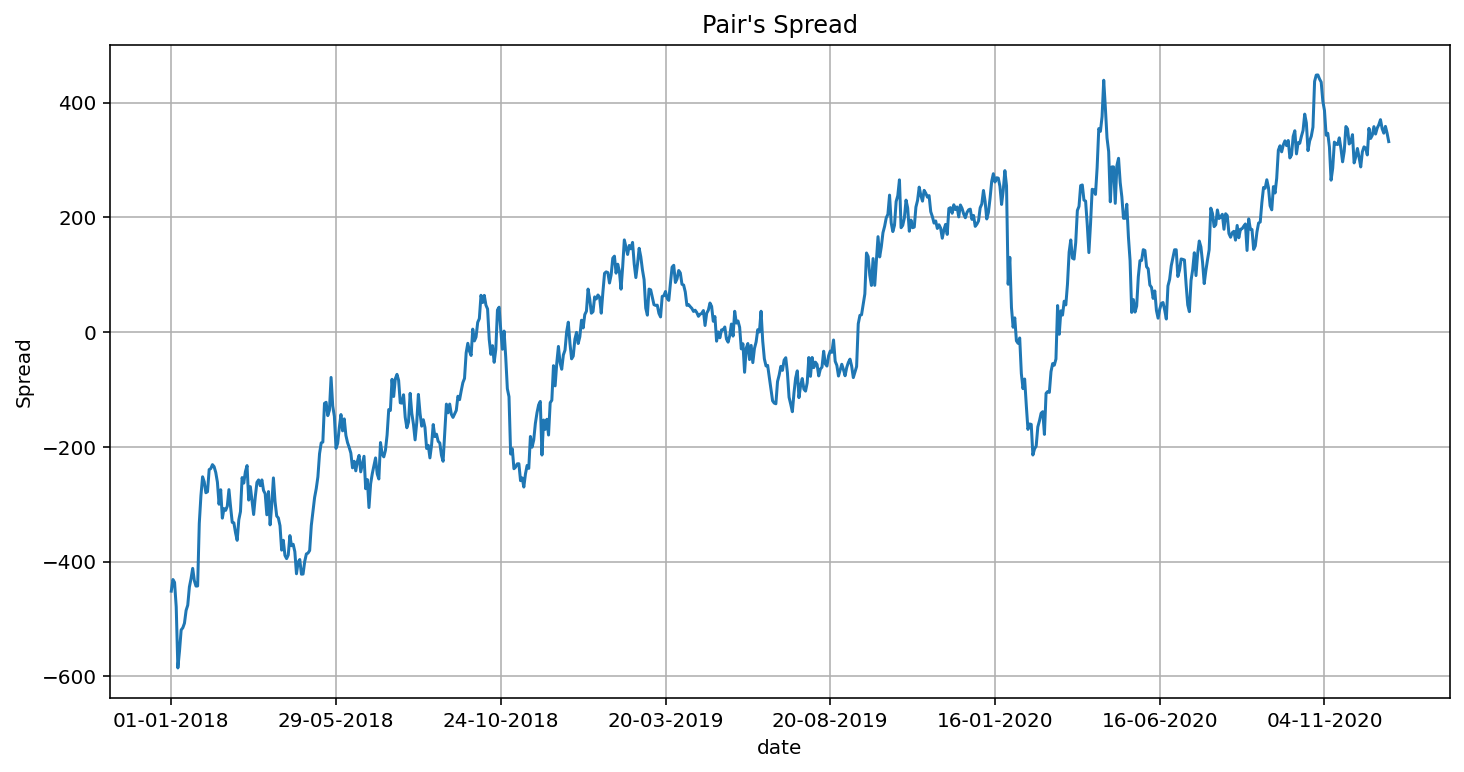

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-2.2105874530237988,
 0.20242528773111546,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 7048.423617663507)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -2.2105874530237988


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1       asset2
date                               
01-01-2021  581.500000  1578.449951
04-01-2021  584.349976  1576.099976
05-01-2021  582.250000  1598.949951
06-01-2021  586.150024  1597.599976
07-01-2021  613.900024  1592.099976

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1       asset2         z  z upper limit  z lower limit
date                                                                       
01-01-2021  581.500000  1578.449951 -0.652211            1.0           -1.0
04-01-2021  584.349976  1576.099976 -0.629119            1.0           -1.0
05-01-2021  582.250000  1598.949951 -0.693881            1.0           -1.0
06-01-2021  586.150024  1597.599976 -0.666956            1.0           -1.0
07-01-2021  613.900024  1592.099976 -0.483815            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

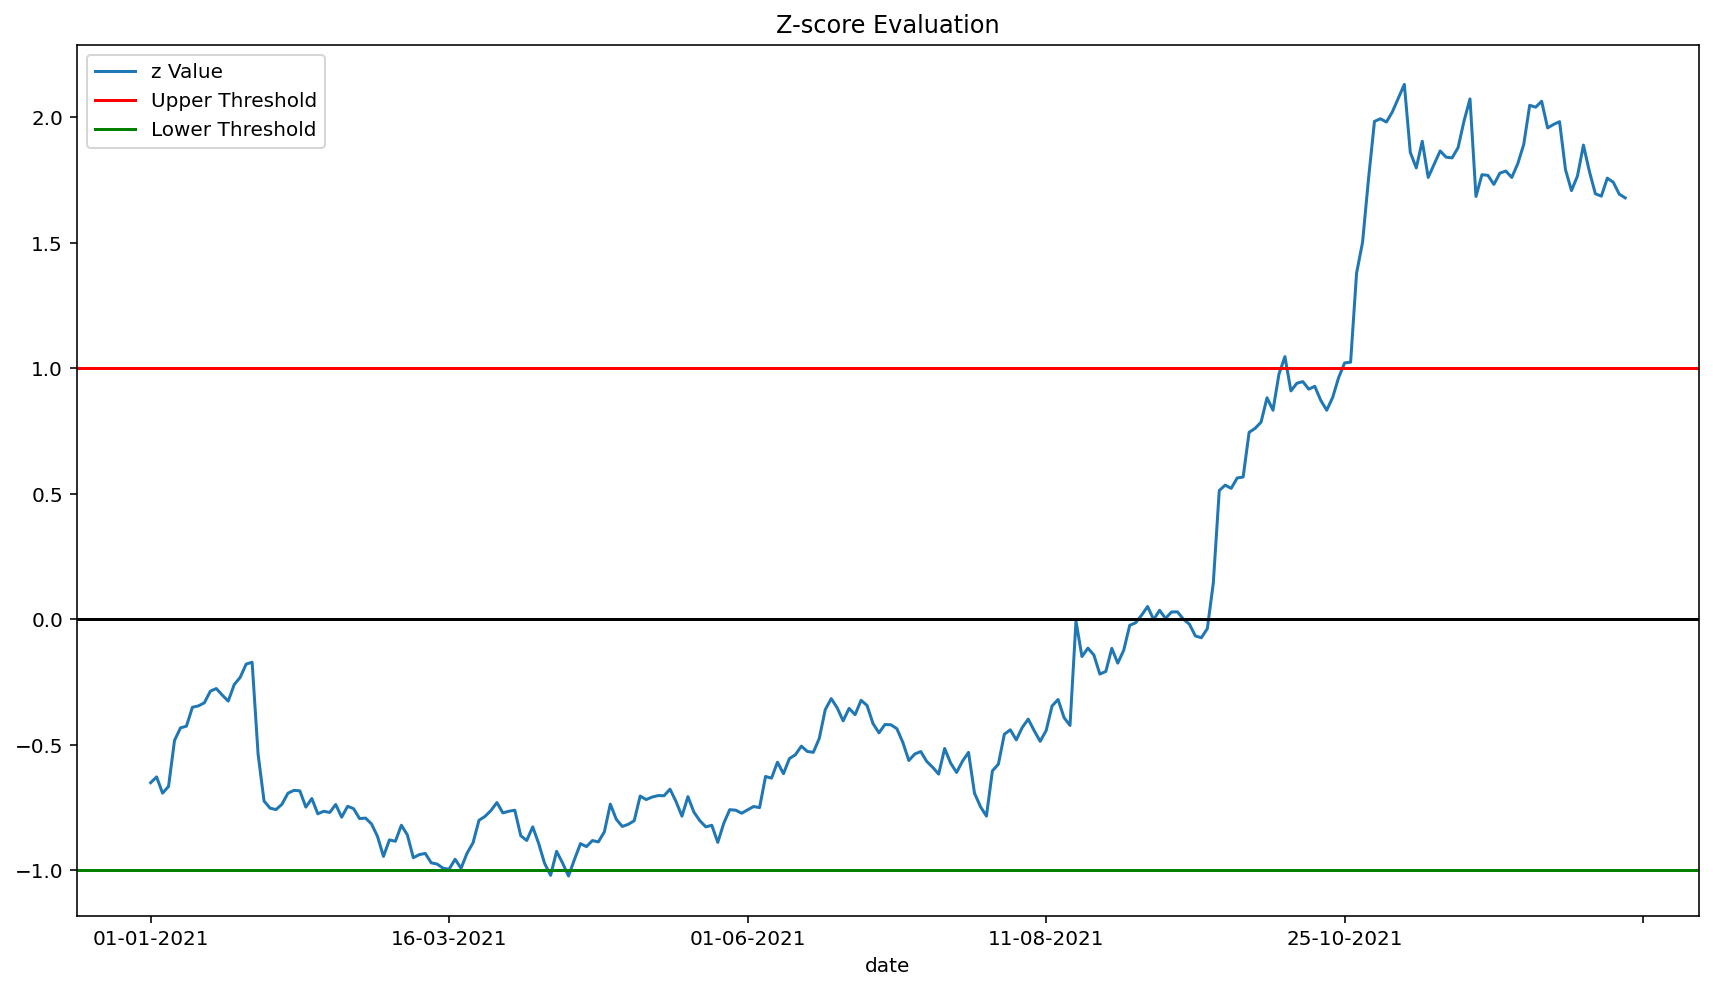

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  581.500000  1578.449951 -0.652211            1.0           -1.0   
04-01-2021  584.349976  1576.099976 -0.629119            1.0           -1.0   
05-01-2021  582.250000  1598.949951 -0.693881            1.0           -1.0   
29-12-2021  891.650024  1455.099976  1.741467            1.0           -1.0   
30-12-2021  888.599976  1461.699951  1.693927            1.0           -1.0   
31-12-2021  898.250000  1481.300049  1.678948            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
29-12-2021        -1         0.0         1         0.0  
30-12-2021        -1         0.0         1         0.0  
31-12-2021        -1         0.0         1         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                          
12-04-2021  515.650024  1559.199951 -1.021337            1.0           -1.0   
16-04-2021  519.049988  1570.849976 -1.024161            1.0           -1.0   
08-10-2021  914.349976  1687.650024  1.046147            1.0           -1.0   
25-10-2021  826.299988  1532.349976  1.021153            1.0           -1.0   
26-10-2021  834.450012  1546.599976  1.024103            1.0           -1.0   
27-10-2021  882.900024  1533.400024  1.379085            1.0           -1.0   
28-10-2021  892.549988  1517.199951  1.501605            1.0           -1.0   
29-10-2021  947.349976  1542.599976  1.754688            1.0           -1.0   
01-11-2021  973.599976  1527.150024  1.983911            1.0           -1.0   
02-11-2021  975.150024  1527.000000  1.994467            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
12-04-2021         1         1.0        -1        -1.0  
16-04-2021         1         1.0        -1        -1.0  
08-10-2021        -1        -1.0         1         1.0  
25-10-2021        -1        -1.0         1         1.0  
26-10-2021        -1         0.0         1         0.0  
27-10-2021        -1         0.0         1         0.0  
28-10-2021        -1         0.0         1         0.0  
29-10-2021        -1         0.0         1         0.0  
01-11-2021        -1         0.0         1         0.0  
02-11-2021        -1         0.0         1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  581.500000  1578.449951 -0.652211            1.0           -1.0   
12-04-2021  515.650024  1559.199951 -1.021337            1.0           -1.0   
13-04-2021  524.200012  1539.650024 -0.925810            1.0           -1.0   
16-04-2021  519.049988  1570.849976 -1.024161            1.0           -1.0   
19-04-2021  517.950012  1536.000000 -0.957742            1.0           -1.0   
16-04-2021  519.049988  1570.849976 -1.024161            1.0           -1.0   
19-04-2021  517.950012  1536.000000 -0.957742            1.0           -1.0   
08-10-2021  914.349976  1687.650024  1.046147            1.0           -1.0   
11-10-2021  895.799988  1697.099976  0.909533            1.0           -1.0   
25-10-2021  826.299988  1532.349976  1.021153            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
12-04-2021         1         1.0        -1        -1.0  
13-04-2021         0        -1.0         0         1.0  
16-04-2021         1         1.0        -1        -1.0  
19-04-2021         0        -1.0         0         1.0  
16-04-2021         1         1.0        -1        -1.0  
19-04-2021         0        -1.0         0         1.0  
08-10-2021        -1        -1.0         1         1.0  
11-10-2021         0         1.0         0        -1.0  
25-10-2021        -1        -1.0         1         1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

515.650024    1
519.049988    1
895.799988    1
Name: asset1, dtype: int64

In [32]:
signals

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  581.500000  1578.449951 -0.652211            1.0           -1.0   
04-01-2021  584.349976  1576.099976 -0.629119            1.0           -1.0   
05-01-2021  582.250000  1598.949951 -0.693881            1.0           -1.0   
06-01-2021  586.150024  1597.599976 -0.666956            1.0           -1.0   
07-01-2021  613.900024  1592.099976 -0.483815            1.0           -1.0   
...                ...          ...       ...            ...            ...   
27-12-2021  884.099976  1456.250000  1.685944            1.0           -1.0   
28-12-2021  899.650024  1464.199951  1.757682            1.0           -1.0   
29-12-2021  891.650024  1455.099976  1.741467            1.0           -1.0   
30-12-2021  888.599976  1461.699951  1.693927            1.0           -1.0   
31-12-2021  898.250000  1481.300049  1.678948            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
06-01-2021         0         0.0         0         0.0  
07-01-2021         0         0.0         0         0.0  
...              ...         ...       ...         ...  
27-12-2021        -1         0.0         1         0.0  
28-12-2021        -1         0.0         1         0.0  
29-12-2021        -1         0.0         1         0.0  
30-12-2021        -1         0.0         1         0.0  
31-12-2021        -1         0.0         1         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

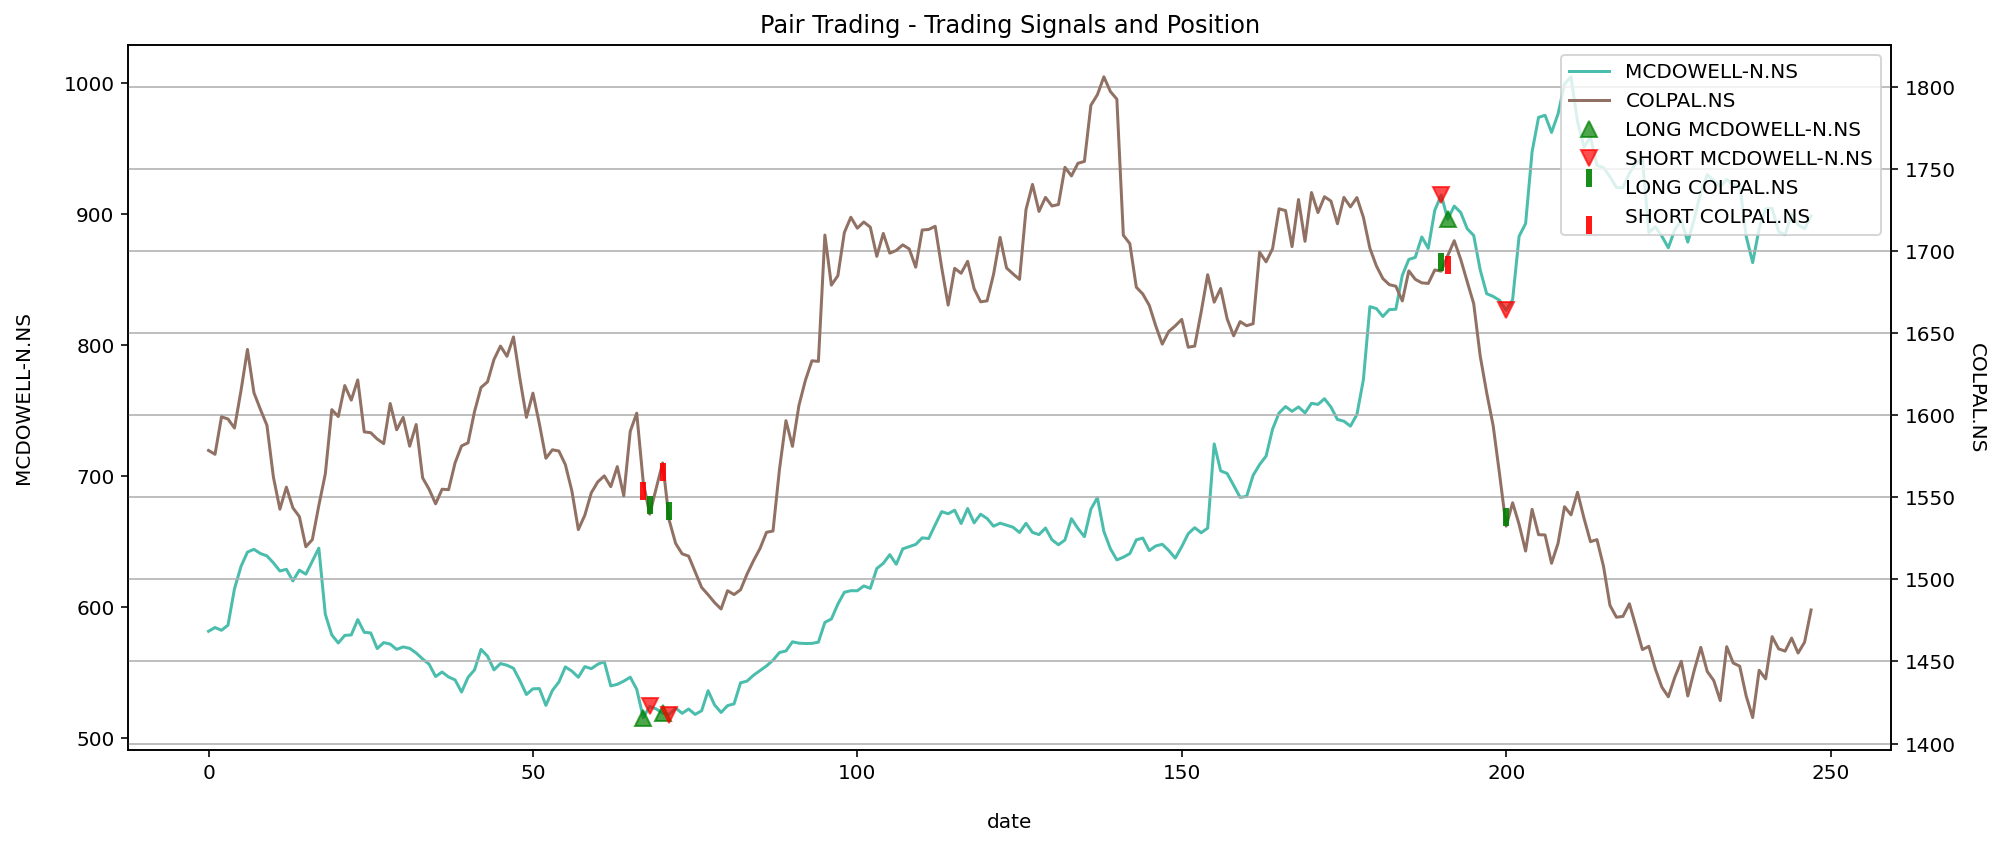

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    581.500000           NaN            NaN            NaN       NaN   
1    584.349976      0.000000  100000.000000  100000.000000       NaN   
2    582.250000      0.000000  100000.000000  100000.000000  0.000000   
3    586.150024      0.000000  100000.000000  100000.000000  0.000000   
4    613.900024      0.000000  100000.000000  100000.000000  0.000000   
243  884.099976 -87525.897584  184377.698792   96851.801208  0.002305   
244  899.650024 -89065.352416  184377.698792   95312.346377 -0.015895   
245  891.650024 -88273.352416  184377.698792   96104.346377  0.008310   
246  888.599976 -87971.397584  184377.698792   96406.301208  0.003142   
247  898.250000 -88926.750000  184377.698792   95450.948792 -0.009910   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   581.500000           NaN            NaN            NaN       NaN   
67  515.650024  51049.352416   48950.647584  100000.000000  0.000000   
68  524.200012      0.000000  100846.448792  100846.448792  0.008464   
70  519.049988  51385.948792   49460.500000  100846.448792  0.000000   
71  517.950012      0.000000  100737.551208  100737.551208 -0.001080   

    positions1  
0          NaN  
67         1.0  
68        -1.0  
70         1.0  
71        -1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    581.500000           NaN            NaN            NaN       NaN   
1    584.349976      0.000000  100000.000000  100000.000000       NaN   
2    582.250000      0.000000  100000.000000  100000.000000  0.000000   
3    586.150024      0.000000  100000.000000  100000.000000  0.000000   
4    613.900024      0.000000  100000.000000  100000.000000  0.000000   
243  884.099976 -87525.897584  184377.698792   96851.801208  0.002305   
244  899.650024 -89065.352416  184377.698792   95312.346377 -0.015895   
245  891.650024 -88273.352416  184377.698792   96104.346377  0.008310   
246  888.599976 -87971.397584  184377.698792   96406.301208  0.003142   
247  898.250000 -88926.750000  184377.698792   95450.948792 -0.009910   

     positions1       asset2     holdings2          cash2   total asset2  \
0           NaN  1578.449951           NaN            NaN            NaN   
1           0.0  1576.099976      0.000000  100000.000000  100000.000000   
2           0.0  1598.949951      0.000000  100000.000000  100000.000000   
3           0.0  1597.599976      0.000000  100000.000000  100000.000000   
4           0.0  1592.099976      0.000000  100000.000000  100000.000000   
243         0.0  1456.250000  80093.750000   19232.493345   99326.243345   
244         0.0  1464.199951  80530.997305   19232.493345   99763.490650   
245         0.0  1455.099976  80030.498680   19232.493345   99262.992025   
246         0.0  1461.699951  80393.497305   19232.493345   99625.990650   
247         0.0  1481.300049  81471.502695   19232.493345  100703.996040   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243 -0.000775         0.0  
244  0.004402         0.0  
245 -0.005017         0.0  
246  0.003657         0.0  
247  0.010821         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   581.500000           NaN            NaN            NaN       NaN   
67  515.650024  51049.352416   48950.647584  100000.000000  0.000000   
68  524.200012      0.000000  100846.448792  100846.448792  0.008464   
70  519.049988  51385.948792   49460.500000  100846.448792  0.000000   
71  517.950012      0.000000  100737.551208  100737.551208 -0.001080   

    positions1       asset2     holdings2          cash2   total asset2  \
0          NaN  1578.449951           NaN            NaN            NaN   
67         1.0  1559.199951 -85755.997305  185755.997305  100000.000000   
68        -1.0  1539.650024      0.000000  101075.245985  101075.245985   
70         1.0  1570.849976 -86396.748680  187471.994665  101075.245985   
71        -1.0  1536.000000      0.000000  102991.994665  102991.994665   

     return2  positions2  
0        NaN         NaN  
67  0.000000        -1.0  
68  0.010752         1.0  
70  0.000000        -1.0  
71  0.018964         1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [46]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

196154.9448322

In [47]:
profit = final_portfolio - 2*initial_capital
profit

-3845.05516779999

In [48]:
roi = (profit/(2*initial_capital))*100
roi

-1.922527583899995

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [45]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 172.843%
